In [2]:
install.packages("randomForest")
install.packages("caTools")
install.packages("caret") #confusionMatrix
install.packages("yardstick")
install.packages("ggplot2")
install.packages("ROCR")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
library(dplyr)
library(randomForest)
library(caTools)
library(caret)

library(yardstick)
library(ggplot2)

library(ROCR)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin


Loading required package: lattice


Attaching package: ‘yardstick’


The following objects are masked from ‘package:caret’:

    precision, recall, sensitivity, specificity




In [4]:
donnees <- read.table("maj_data.data", header = TRUE, sep = ",")

In [5]:
head(donnees)

,X,X2,X30,X2.1,X1,X2.2,X2.3,X2.4,X2.5,X1.1,⋯,X2.7,X2.8,X2.9,X2.10,X1.00,X85,X18,X4.0,X.,X1.2
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>
1,1,2,50,1,1,2,1,2,2,1,⋯,2,2,2,2,0.9,135.000,42,3.5,61.85227,1
2,2,2,78,1,2,2,1,2,2,2,⋯,2,2,2,2,0.7,96.000,32,4.0,61.85227,1
3,4,2,34,1,2,2,2,2,2,2,⋯,2,2,2,2,1.0,105.488,200,4.0,61.85227,1
4,5,2,34,1,2,2,2,2,2,2,⋯,2,2,2,2,0.9,95.000,28,4.0,75.00000,1
5,8,2,39,1,2,2,1,2,2,2,⋯,2,2,2,2,0.7,105.488,48,4.4,61.85227,1
6,9,2,30,1,2,2,2,2,2,2,⋯,2,2,2,2,1.0,105.488,120,3.9,61.85227,1


In [9]:
print(colnames(donnees))

 [1] "X"     "X2"    "X30"   "X2.1"  "X1"    "X2.2"  "X2.3"  "X2.4"  "X2.5" 
[10] "X1.1"  "X2.6"  "X2.7"  "X2.8"  "X2.9"  "X2.10" "X1.00" "X85"   "X18"  
[19] "X4.0"  "X."    "X1.2" 


In [11]:
#On identifie automatiquement les variables potentielles dépendantes
variables_dependantes_potentielles <- character(0)

for (col in names(donnees)) {
  unique_vals <- unique(donnees[[col]])

  #On vérifie si la variable a seulement deux niveaux (binaire)
  if (length(unique_vals) == 2) {
    variables_dependantes_potentielles <- c(variables_dependantes_potentielles, col)
  }
}

#On affiche les variables potentielles dépendantes
print(variables_dependantes_potentielles)

 [1] "X2"    "X2.1"  "X1"    "X2.2"  "X2.3"  "X2.4"  "X2.5"  "X1.1"  "X2.6" 
[10] "X2.7"  "X2.8"  "X2.9"  "X2.10" "X1.2" 


In [65]:
#Fonction permettant l'application du modèle RandomForest
# parametres : le dataset, le paramètre d'interet

fonctionRF <- function(donnees, interet) {

  set.seed(123)

  #Faire de la variable dependante un facteur (categorique)
  #donnees[[interet]] pour donnees$interet
  donnees[[interet]] <- as.factor(donnees[[interet]])

  #echantillonnage trainset et testset
  ind <- sample(2, nrow(donnees), replace = TRUE, prob=c(0.7, 0.3))
  data_train <- donnees[ind == 1,]
  data_test <- donnees[ind == 2,]


  #construction du modele
  rf <- randomForest(as.formula(paste(interet, "~ .")), data=data_train, ntree=5000, mtry = 2)
  print(rf)
  cat("\n\n")

  #prediction
  pred <- predict(rf, data_test)

  #Matrice de confusion
  mat_conf <- table(observed = data_test[[interet]], predicted = pred)
  cat("Matrice de condusion sur de nouvelles données:\n\n")
  print(mat_conf)

  return(list(rf, data_train, data_test, mat_conf))
}

In [66]:
model_rf <- fonctionRF(donnees, "X1.1")

donnees_rf <- model_rf[[1]]
donnees_train <- model_rf[[2]]
donnees_test <- model_rf[[3]]
mat_c <- model_rf[[4]]


Call:
 randomForest(formula = as.formula(paste(interet, "~ .")), data = data_train,      ntree = 5000, mtry = 2) 
               Type of random forest: classification
                     Number of trees: 5000
No. of variables tried at each split: 2

        OOB estimate of  error rate: 18.68%
Confusion matrix:
  1  2 class.error
1 0 17           1
2 0 74           0


Matrice de condusion sur de nouvelles données:

        predicted
observed  1  2
       1  1  4
       2  0 32


In [14]:
getPrecision_Recall_FScore <- function(mat_conf) {
  #On extrait les valeurs de la matrice de confusion
  tp <- mat_conf[2, 2]  # True Positives
  fp <- mat_conf[1, 2]  # False Positives
  fn <- mat_conf[2, 1]  # False Negatives

  print(tp)
  print(fp)
  print(fn)

  # Calculer la précision, le rappel et le F-score
  precision <- tp / (tp + fp)
  recall <- tp / (tp + fn)
  fscore <- 2 * (precision * recall) / (precision + recall)


  # Afficher les résultats
  cat("Precision:", precision, "\n")
  cat("Recall:", recall, "\n")
  cat("Fscore:", fscore, "\n")

  return(c(precision,recall,fscore))
}

In [67]:
res <- getPrecision_Recall_FScore(mat_c)

[1] 32
[1] 4
[1] 0
Precision: 0.8888889 
Recall: 1 
Fscore: 0.9411765 


In [89]:
afficheROC <- function(rf,donnee,interet){

  pred1 <- predict(rf,type = "prob")

  print(dim(pred1))
  print(dim(donnee))

  perf <- prediction(pred1[,2], donnee)


  #AUC
  auc <- performance(perf, "auc")
  auc

  #TPR FPR
  pred3 <- performance(perf, "tpr","fpr")

  #ROC curve
  plot(pred3,main="ROC Curve pour le Random Forest",col=2,lwd=2)
  abline(a=0,b=1,lwd=2,lty=2,col="gray")
}

In [108]:
afficheROC <- function(rf,donnees_test,interet){

  #Prédiction des probabilités avec le modèle de forêt aléatoire sur le jeu de données de test
  pred_prob <- predict(rf, newdata = donnees_test, type = "prob")

  #Extraction des probabilités associées à la classe positive (2ème colonne)
  pred_positive <- pred_prob[, 2]

  #Obtention des vraies étiquettes (valeurs de la variable cible) à partir du jeu de données de test
  true_labels <- donnees_test[[interet]]

  #Création d'un objet de performance en utilisant les probabilités prédites et les vraies étiquettes
  perf <- prediction(pred_positive, true_labels)

  #AUC
  auc <- performance(perf, "auc")
  cat("AUC = ", auc@y.values[[1]])

  #TPR FPR
  pred3 <- performance(perf, "tpr","fpr")

  #ROC curve
  plot(pred3,main="ROC Curve pour le Random Forest",col=2,lwd=2)
  abline(a=0,b=1,lwd=2,lty=2,col="gray")
}

AUC =  0.7375

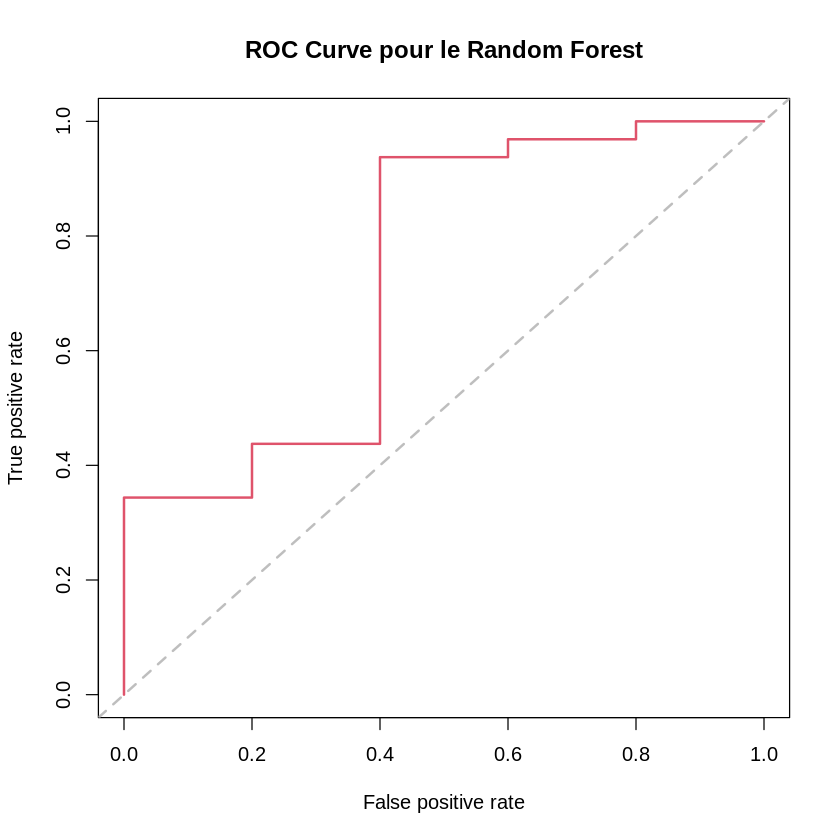

In [109]:
afficheROC(donnees_rf,donnees_test,"X1.1")